## Задача: Реализовать сентимент-анализ русского текста с использованием классического ML

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pymorphy2
from pymorphy2 import MorphAnalyzer

from xgboost import XGBClassifier
import pickle

#Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

#NLTK
import nltk
from nltk.corpus import stopwords

# Preprocessing

Для начала импортируем данные и посмотрим за них.

In [2]:
df = pd.read_json('DataSet_pred.json')
df.head(10)

,text,sentiment
0,d touch просто восхитительный вещь заряд держа...,1
1,отключаться температура близкий нуль непонятно...,1
2,apple окончательно решить заморачиваться делат...,0
3,постараться наиболее ёмко коротко описать осно...,1
4,достойный телефон пользоваться один удовольствие,1
5,s gold gb,1
6,первый айфон сказать честно эппл ранее рука де...,1
7,очень понравиться этот модель вопервое классны...,1
8,долгий время пользоваться iphone s gb устраива...,1
9,ранний samsung galaxy alpha smgf gb купить iph...,1


Проверим датасет на наличие пропущенных значений.

In [8]:
df['sentiment'].unique()

array([1, 0], dtype=int64)

In [9]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

Мы видим присутствие пропущенных значений, необходимо их удалить.

In [26]:
df = df[df['text'].notna()]

In [27]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

Избавились от пропущенных значений, теперь можно продолжать предобработку

Функция предобработки данных.

In [12]:
def preprocessing(texts):
    new_text = []
    for i in tqdm(range(len(texts))):
        text = texts[i]
        stop_free = " ".join([i for i in text.lower().split() if i not in stop_words])
        punc_free = ''.join(ch for ch in stop_free if ch not in spec_chars)
        lem_text = " ".join([lemma.parse(word)[0].normal_form for word in punc_free.split(' ')])
        new_text.append(lem_text)
    return new_text

In [ ]:
#Запуск функции предобработки
nltk.download("stopwords")
stop_words = stopwords.words('russian')
lemma = pymorphy2.MorphAnalyzer()
spec_chars = string.punctuation + string.digits + '\n\xa0«»\t-—–“”→...'
texts = df.text.values.tolist()
df.text = preprocessing(texts)

C:\Users\isaev\AppData\Local\Temp/ipykernel_8464/623599038.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(texts))):


  0%|          | 0/462066 [00:00<?, ?it/s]

# Machine Learning

In [3]:
model_classes = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]

model_names = ['LogisticRegression','DecisionTree', 'Random Forest',  'XGBoost']

metrics = {'F1_Score':f1_score, 'Accuracy': accuracy_score, 'Precision': precision_score, 'Recall': recall_score}

parameters_logregr = [{'GS_CV_logregr':[LogisticRegression()], 'GS_CV_logregr__C': [0.0001, 0.001, 0.01, 0.1, 1],
                       'GS_CV_logregr__random_state': [50]}]
parameters_tree = [{'GS_CV_tree':[DecisionTreeClassifier()], 'GS_CV_tree__criterion':["entropy"],
                    'GS_CV_tree__random_state': [50]}]
parameters_rf = [{'GS_CV_RF':[RandomForestClassifier()], 'GS_CV_RF__n_estimators': [200, 500],
                  'GS_CV_RF__max_depth': [6, 9], 'GS_CV_RF__random_state': [50]}]
parameters_xgb = [{'GS_CV_xgb':[XGBClassifier()], 'GS_CV_xgb__learning_rate': [0.9],
                   'GS_CV_xgb__n_estimators': [200, 500], 'GS_CV_xgb__max_depth': [6, 9], 'GS_CV_xgb__random_state': [50],
                   'GS_CV_xgb__eval_metric':["mlogloss"], 'GS_CV_xgb__use_label_encoder': ["False"]}]

compare = pd.DataFrame([])

Split into train and test.

In [4]:
X = df.text
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

Функция вычисления метрик.

In [5]:
def calculate_metrics(y_test, y_pred, metrics={}):
    if len(metrics) == 0:
        raise ValueError('metrics are empty')
        
    results = dict()
    for key in metrics:
        results[key] = metrics[key](y_test, y_pred)
    
    return results

### Настраиваем гиперпараметры для каждой модели и вычисляем метрики.

#### 1. LogisticRegression

In [9]:
pipeline = Pipeline([('TF-IDF', TfidfVectorizer(min_df=0.01, max_df=0.9)),
                     ('GS_CV_logregr', LogisticRegression())])
    
grid_search = GridSearchCV(pipeline, param_grid=parameters_logregr, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
y_predict_logreg = best_clf.predict(X_test)
    
res_logregr = calculate_metrics(y_test, y_predict_logreg, metrics=metrics)  
compare = compare.append(res_logregr, ignore_index=True)

#### 2. DecisionTreeClassifier

In [8]:
pipeline = Pipeline([('TF-IDF', TfidfVectorizer(min_df=0.01, max_df=0.9)),
                     ('GS_CV_tree', DecisionTreeClassifier())])
    
grid_search_ = GridSearchCV(pipeline, param_grid=parameters_tree, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
y_predict_tree = best_clf.predict(X_test)
    
res_tree = calculate_metrics(y_test, y_predict_tree, metrics=metrics)  
compare = compare.append(res_tree, ignore_index=True)

#### 3. RandomForestClassifier

In [10]:
pipeline = Pipeline([('TF-IDF', TfidfVectorizer(min_df=0.01, max_df=0.9)),
                     ('GS_CV_RF', RandomForestClassifier())])
    
grid_search = GridSearchCV(pipeline, param_grid=parameters_rf, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
y_predict_rf = best_clf.predict(X_test)
    
res_rf = calculate_metrics(y_test, y_predict_rf, metrics=metrics)  
compare = compare.append(res_rf, ignore_index=True)

#### 4. XGBoost Classifier

In [6]:
pipeline = Pipeline([('TF-IDF', TfidfVectorizer(min_df=0.01, max_df=0.9)),
                     ('GS_CV_xgb', XGBClassifier())])
    
grid_search_xgb = GridSearchCV(pipeline, param_grid=parameters_xgb, cv=5, scoring="accuracy")
grid_search_xgb.fit(X_train, y_train)

best_clf = grid_search_xgb.best_estimator_
y_predict_xgb = best_clf.predict(X_test)
    
res_xgb = calculate_metrics(y_test, y_predict_xgb, metrics=metrics)  
compare = compare.append(res_xgb, ignore_index=True)

C:\Users\isaev\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\isaev\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\isaev\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use 

C:\Users\isaev\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\isaev\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [8]:
best_clf

Pipeline(steps=[('TF-IDF', TfidfVectorizer(max_df=0.9, min_df=0.01)),
                ('GS_CV_xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='mlogloss', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.9, max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=50, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder='False',
           

### Выгрузка обученной модели в формате .pickle

In [6]:
path = 'Sentiment_model.pickle'
with open(path, 'wb') as file:
    pickle.dump(grid_search_xgb, file)

NameError: name 'grid_search_xgb' is not defined

Сохраним все вычесленные метрики в единый датафрейм и выведем его.

In [19]:
compare.index = model_names
compare

,F1_Score,Accuracy,Prescision,Recall
LogisticRegression,0.872653,0.803255,0.828862,0.921328
DecisionTree,0.914395,0.874182,0.910410,0.918415
Random Forest,0.847676,0.737261,0.736064,0.999184
XGBoost,0.915290,0.873467,0.897032,0.934307


### Comparison
Для наглядности сравнения моделей, визуализируем данные по одной из метрик (в нашем случае выбираем в качестве показателя - F1 меру)

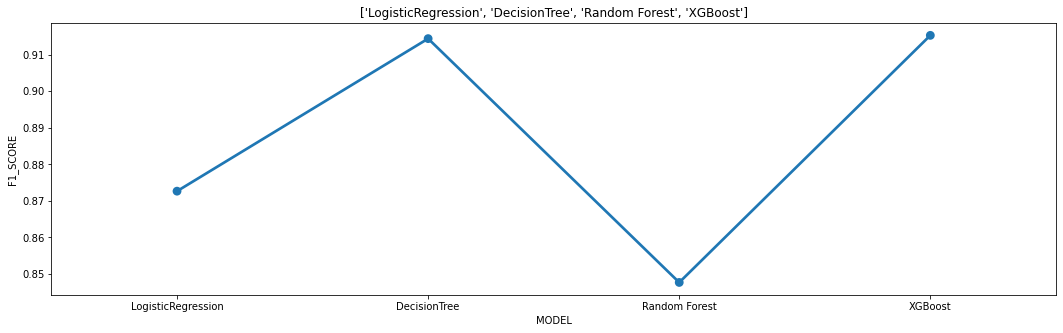

In [20]:
plt.figure(figsize=(18,5))

sns.pointplot(x=model_names,y='F1_Score',data=compare)

plt.title(model_names)
plt.xlabel('MODEL')
plt.ylabel('F1_SCORE')
plt.show()

Вывод: Из графика выше видим, что у модели "XGBoost" показатель метрики F1_мера выше, чем у остальных сравниваемых моделей.

### Подгргузка файла .pickle с обученной моделью

In [9]:
path = 'Sentiment_model.pickle'
with open(path, 'rb') as file:
    model = pickle.load(file)

In [10]:
def prediction(text):
    texts = [text]
    prepr_tockens = preprocessing(texts)
    prepr_text = [' '.join(prepr_tockens)]

    label_pred = model.predict(prepr_text)

    if label_pred[0] == 1:
        return 'Positive'
    else:
        return 'Negative'

In [15]:
lemma = pymorphy2.MorphAnalyzer()
spec_chars = string.punctuation + string.digits + '\n\xa0«»\t-—–“”→...'
prediction('Я люблю маму')

C:\Users\isaev\AppData\Local\Temp/ipykernel_13568/623599038.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(texts))):


  0%|          | 0/1 [00:00<?, ?it/s]

'Positive'

In [18]:
prediction('Смартфон плохой')

C:\Users\isaev\AppData\Local\Temp/ipykernel_13568/623599038.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(texts))):


  0%|          | 0/1 [00:00<?, ?it/s]

'Negative'

In [19]:
prediction('Я себя отлично чувствую')

C:\Users\isaev\AppData\Local\Temp/ipykernel_13568/623599038.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(texts))):


  0%|          | 0/1 [00:00<?, ?it/s]

'Positive'

In [23]:
prediction('Я плохо себя чувствую')

C:\Users\isaev\AppData\Local\Temp/ipykernel_13568/623599038.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(texts))):


  0%|          | 0/1 [00:00<?, ?it/s]

'Negative'